# Building the final scratch model

In [5]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-01-25 09:03:25.683983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading image metadata

In [6]:
def get_image_meta(data_path):
    """Retrieve basic metadata (file_path, category)"""
    
    file_meta = []

    for name in os.listdir(data_path): 
        filepath = os.path.join(data_path, name)

        if '.DS_Store' in filepath:
            continue

        for image_file_name in os.listdir(filepath): 
            image_filepath = os.path.join(filepath, image_file_name)

            attrs = {
                'category': name,
                'file_path': image_filepath,
            }
            file_meta.append(attrs)

    return file_meta 

In [7]:
data_file_path = "../data/clean_fer_2013/"

In [8]:
train_data_folder = data_file_path + "train/"

meta_train = get_image_meta(train_data_folder)

df_meta_train = pd.DataFrame(meta_train)
df_meta_train.head()

category                                          file_path
0    happy  ../data/clean_fer_2013/train/happy/Training_50...
1    happy  ../data/clean_fer_2013/train/happy/Training_70...
2    happy  ../data/clean_fer_2013/train/happy/Training_85...
3    happy  ../data/clean_fer_2013/train/happy/Training_44...
4    happy  ../data/clean_fer_2013/train/happy/Training_63...

In [9]:
val_data_folder = data_file_path + "validation/"

meta_val = get_image_meta(val_data_folder)

df_meta_val = pd.DataFrame(meta_val)
df_meta_val.head()

category                                          file_path
0    happy  ../data/clean_fer_2013/validation/happy/Public...
1    happy  ../data/clean_fer_2013/validation/happy/Public...
2    happy  ../data/clean_fer_2013/validation/happy/Public...
3    happy  ../data/clean_fer_2013/validation/happy/Public...
4    happy  ../data/clean_fer_2013/validation/happy/Public...

## Base Scratch Model Configuration

Here I rebuild the base model I built earlier.

In [26]:
input_shape = (48,48,1)
num_categories = 7 # we have 7 emotions

base_model = tf.keras.Sequential([
    keras.layers.InputLayer(shape=input_shape),

    # First Convolutional Layer (32 filters)
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Layer (64 filters)
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Layer (128 filters)
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),

    # Final output layer
    keras.layers.Dense(num_categories, activation='softmax') 
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

base_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

base_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,335 (2.64 MB)

 Trainable params: 691,335 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

## Preparing the datasets for training

I need a `label_encoder` to one-hot-encode the categories (which are currently in string format).

I have also added a `preprocess_input` function. At the moment this normalizes the image (converting all pixels into a [0,1] range) but it can be expanded in the future to perform additional steps e.g. to resize images and convert images to grayscale.

I shuffle the dataset to prevent any kind of order bias.

I use `prefetch` to improve performance: it will start preparing the next batch of data while the model is training the current batch.

We start with a batch_size of 32 to balance memory consumption (not too much data is loaded into memory) and speed (might take longer than a larger batch size but hopefully not too bad).

In [25]:
# Augmentation Layers
rotation_layer = tf.keras.layers.RandomRotation(0.05)  # Rotate by up to 5% of 360 degrees i.e. 18 degrees
zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.05, width_factor=0.05)  # Zoom by 5%
shift_layer = tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05)  # Shift by 5%
flip_layer = tf.keras.layers.RandomFlip("horizontal")

def augment_image(image):
    """Augment the image with a random rotation, zoom, translation and flip"""
    image = rotation_layer(image) 
    image = zoom_layer(image) 
    image = shift_layer(image)  
    image = flip_layer(image)
    
    return image



def preprocess_input(image_path, should_augment_image=False):
    """Preprocess Input"""
    try:
        image_file = tf.io.read_file(image_path)
    except:
        print(f"Issue loading {image_file}")
        return None

    image = tf.image.decode_jpeg(image_file, channels=1)
    image = tf.image.resize(image, (48, 48))

    if should_augment_image:
        image = augment_image(image)
        
    image = image / 255.0 
    return image

def create_label_encoder(categories):
    """Create a mapping from category names to integer indices and perform one hot encoding"""
    return tf.keras.layers.StringLookup(vocabulary=categories, 
                                                output_mode='one_hot', 
                                                num_oov_indices=0)

def create_dataset(image_paths, labels, label_encoder, should_augment_image=False, batch_size=32):
    """Load the dataset from file paths, apply preprocessing and group into batches"""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_input(x,should_augment_image=should_augment_image), tf.squeeze(label_encoder(y))))
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(buffer_size=1000)  # Shuffle the dataset
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # Prefetch for better performance
    return dataset

In [22]:
train_labels = df_meta_train["category"].values
train_image_paths = df_meta_train["file_path"].values

val_labels = df_meta_val["category"].values
val_image_paths = df_meta_val["file_path"].values

categories = list(df_meta_train["category"].unique())
label_encoder = create_label_encoder(categories)

train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=False, batch_size=32)
val_dataset = create_dataset(val_image_paths, val_labels, label_encoder, should_augment_image=False, batch_size=32)

In [23]:
expected_num_iterations_per_epoch = len(train_dataset)
length_training_data = len(train_dataset) * 32
length_validation_data = len(val_dataset) * 32

expected_num_iterations_per_epoch, length_training_data, length_validation_data

(837, 26784, 3488)

## Training the base model

I train the initial base model across 30 epochs to get a sense of its general performance. The default learning rate seems quite low so I wanted to train for more than the standard 10 epochs.

In [31]:
base_history = base_model.fit(
    train_dataset,          
    epochs=30,           
    validation_data=val_dataset  
)

Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.2525 - loss: 1.8344 - val_accuracy: 0.2432 - val_loss: 1.8222
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2291 - loss: 1.8204 - val_accuracy: 0.2277 - val_loss: 1.8486
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2527 - loss: 1.8032 - val_accuracy: 0.2516 - val_loss: 1.8064
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2731 - loss: 1.8065 - val_accuracy: 0.1872 - val_loss: 1.8615
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2669 - loss: 1.8139 - val_accuracy: 0.2516 - val_loss: 1.7969
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2533 - loss: 1.7722 - val_accuracy: 0.2895 - val_loss: 1.7403
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2737 - loss: 1.7372 - val_accuracy: 0.3292 - val_loss: 1.6611
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3255 - loss: 1.6580 - val_accuracy: 0

**Evaluation**

Looking at these first results, you can see that the accuracy on the validation set doesn't get much better than 50%. 

You can also see that the validation loss starts to increase after around 18 epochs, which can be an indication of overfitting.

50% is not a great accuracy score and training for longer with the current model doesn't seem to help. Before we start tweaking our current model, it would be interesting to see if a pretrained model will give us better performance. 

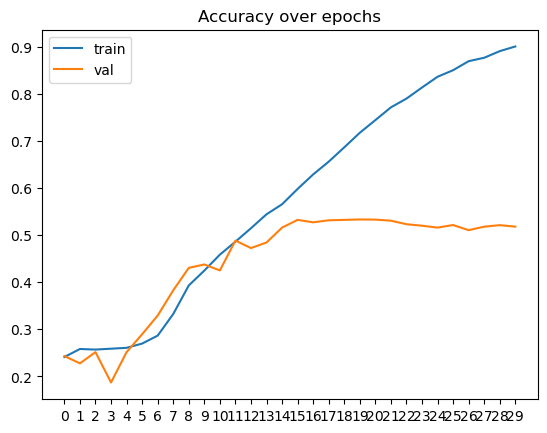

In [35]:
plt.plot(base_history.history["accuracy"], label="train")
plt.plot(base_history.history["val_accuracy"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

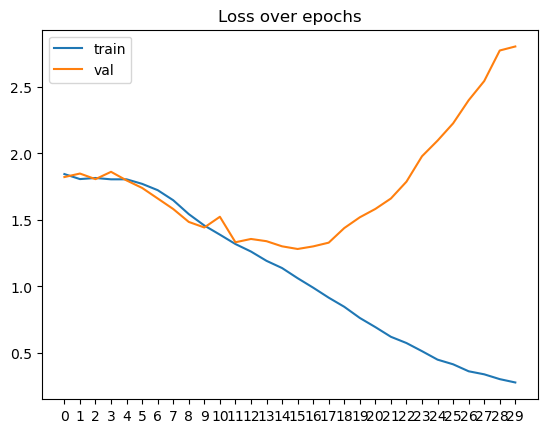

In [36]:
plt.plot(base_history.history["loss"], label="train")
plt.plot(base_history.history["val_loss"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Improving the model

In [29]:
def build_model(learning_rate=0.001, dense_layer_units=[128,64], drop_rate=0):
    input_shape = (48,48,1)
    num_categories = 7 

    base_model = tf.keras.Sequential([
        keras.layers.InputLayer(shape=input_shape),
    
        # First Convolutional Layer (32 filters)
        keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
        # Second Convolutional Layer (64 filters)
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
        # Third Convolutional Layer (128 filters)
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Flatten()
    ])

    # Add additional dense layers
    for unit in dense_layer_units:
        base_model.add(keras.layers.Dense(unit, activation='relu'))
        # Add dropout
        if drop_rate > 0:
            base_model.add(keras.layers.Dropout(drop_rate))
            
    
    # Final output layer
    base_model.add(keras.layers.Dense(num_categories, activation='softmax')) 

    optimizer = keras.optimizers.Adam(learning_rate)
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=False)
    
    base_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return base_model
    

### 1. Class Imbalance: adjust the loss function

We know we have an imbalanced dataset and we explored methods of rectifying this in the EDA. I will go with the simplest approach for just now: adjusting the loss function so that under-represented classes have larger weight when the loss function is calculated. I can achieve this by passing in a class_weight dictionary. 

In [10]:
category_counts = df_meta_train["category"].value_counts().reset_index().sort_values(by="category").reset_index(drop=True)
category_counts["weights"] = np.sum(category_counts["count"])/ category_counts["count"]
category_counts["normalized_weights"] = category_counts["weights"]/ np.sum(category_counts["weights"])
category_counts

category  count    weights  normalized_weights
0     angry   3712   7.210938            0.064508
1   disgust    372  71.954301            0.643693
2      fear   3790   7.062533            0.063180
3     happy   6959   3.846386            0.034409
4   neutral   4731   5.657789            0.050614
5       sad   4581   5.843047            0.052271
6  surprise   2622  10.208619            0.091325

In [18]:
class_weight_dict = dict(zip(category_counts.index, category_counts["normalized_weights"]))
class_weight_dict

{0: 0.06450800153432945,
 1: 0.6436927464930938,
 2: 0.06318039622570737,
 3: 0.03440921133717932,
 4: 0.05061376066274168,
 5: 0.052271054725044945,
 6: 0.09132482902190346}

In [17]:
# We use the same model configuration as before
class_weight_model = build_model()

class_weight_history = class_weight_model.fit(
    train_dataset,          
    epochs=30,           
    validation_data=val_dataset,
    class_weight=class_weight_dict # Add Class Weights
)

(837, 26784, 3488)

In [ ]:
plt.plot(class_weight_history.history["accuracy"], label="train")
plt.plot(class_weight_history.history["val_accuracy"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

In [ ]:
plt.plot(class_weight_history.history["loss"], label="train")
plt.plot(class_weight_history.history["val_loss"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Loss over epochs")
plt.show()

**Evaluation**


TODO
TODO
TODO

### 2. Data Augmentation

I have added an additional function to our dataset creator that will augment images. I have chosen the same settings used in the EDA.

I apply transformations to the training dataset but NOT the validation dataset. When we use this in the training dataset, changes are applied randomly but we do not want randomness in our validation dataset: we want the same dataset to be evaluated against each model so we do not change this.

In [26]:
# We use the same model configuration as before
data_aug_model = build_model()

# We now add augmentation to our training set
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=True, batch_size=32)

expected_num_iterations_per_epoch = len(train_dataset)
length_training_data = len(train_dataset) * 32
length_validation_data = len(val_dataset) * 32

# Augmentation ddoes not change the number of images just 
expected_num_iterations_per_epoch, length_training_data, length_validation_data

Augmenting


(837, 26784, 3488)

In [ ]:
data_aug_history = data_aug_model.fit(
    train_dataset,          
    epochs=30,           
    validation_data=val_dataset,
    class_weight=class_weight_dict ## TBD if should add
)

In [ ]:
plt.plot(data_aug_history.history["accuracy"], label="train")
plt.plot(data_aug_history.history["val_accuracy"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

In [ ]:
plt.plot(data_aug_history.history["loss"], label="train")
plt.plot(data_aug_history.history["val_loss"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Loss over epochs")
plt.show()

**Evaluation**


TODO
TODO
TODO

### 3. Modifying the Learning Rate

The default learning rate is `0.001`. We can experiment to see if a slower or faster learning rate works better for this model.

In [ ]:
# TBD, we will use the augmented training set
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=True, batch_size=32)

lr_scores = {}

for lr in [0.0001,0.001,0.01,0.1]:
    print(lr)
    
    model = build_model(learning_rate=lr)

    history = model.fit(
        train_dataset,          
        epochs=30,           
        validation_data=val_dataset,
        class_weight=class_weight_dict ## TBD if should add
    )
    lr_scores[lr] = history.history

    print()
    print()

In [ ]:
for lr, hist in lr_scores.items():
    plt.plot(hist["val_accuracy"], label=lr)
plt.xticks(np.arange(30))
plt.legend()
plt.show()

In [ ]:
for lr, hist in lr_scores.items():
    plt.plot(hist["val_loss"], label=lr)
plt.xticks(np.arange(30))
plt.legend()
plt.show()

**Evaluation**


TODO
TODO
TODO

### 4. Modifying the Dense layers

More layers means more complexity. Our base model has 2 dense layers, excluding the output layer.

If the model is underfitting, it means that it is not capturing enough patterns and so adding additional dense layers may prove helpful.

If the model is overfitting and performing too well on training data but badly on new data then removing layers can simplify the model and improve generalization.

We will try a few permutations, ranging from removing the 2 additional layers entirely to adding an extra one.

In [ ]:
# TBD, we will use the augmented training set
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=True, batch_size=32)

learning_rate=TBD
dlu_scores = {}

dlu_array = [[],[32],[64,32],[128,64],[128,64,32]]

for dlu in dlu_array:
    print(dlu)
    
    model = build_model(learning_rate=learning_rate,dense_layer_units=dlu)

    history = model.fit(
        train_dataset,          
        epochs=30,           
        validation_data=val_dataset,
        class_weight=class_weight_dict ## TBD if should add
    )
    dlu_scores[dlu] = history.history

    print()
    print()

In [ ]:
for dlu, hist in dlu_scores.items():
    #plt.plot(hist["accuracy"], label=(f'train={dlu}'))
    plt.plot(hist["val_accuracy"], label=(f'val={dlu}'))
plt.xticks(np.arange(30))
#plt.yticks([0.78,0.80,0.82,0.825,0.83])
plt.legend()
plt.show()

In [ ]:
for dlu, hist in dlu_scores.items():
    plt.plot(hist["val_loss"], label=dlu)
plt.xticks(np.arange(30))
plt.legend()
plt.show()

**Evaluation**


TODO
TODO
TODO

### 5. Regularization via Dropout

Dropout is a way of regularizing our neural net. We want to reduce the liklihood that our model will learn an irrelevant rule. Dropout forces the model to focus on the bigger picture and can prevent overfitting.

During training we randomly drop or deactive a certain percentage of neurons in a layer which temporarily makes them inactive in that training step which means their outputs don't contribute to the forward pass or the gradient updates during back propagation. When neurons are dropped randomly, the network can't rely on a given neuron, which prevents overfitting.

In [ ]:
# TBD, we will use the augmented training set
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=True, batch_size=32)

learning_rate=TBD
dense_layer_units = TBD

dr_scores = {}

for dr in [0.0,0.2,0.5,0.8]:
    print(dr)
    
    model = build_model(learning_rate=learning_rate,dense_layer_units=dense_layer_units, drop_rate=dr)

    history = model.fit(
        train_dataset,          
        epochs=30,           
        validation_data=val_dataset,
        class_weight=class_weight_dict ## TBD if should add
    )
    dr_scores[dr] = history.history

    print()
    print()

In [ ]:
for dr, hist in dr_scores.items():
    #plt.plot(hist["accuracy"], label=(f'train={dr}'))
    plt.plot(hist["val_accuracy"], label=(f'val={dr}'))
plt.xticks(np.arange(30))
#plt.yticks([0.78,0.80,0.82,0.825,0.83])
plt.legend()
plt.show()

In [ ]:
for dr, hist in dr_scores.items():
    plt.plot(hist["val_loss"], label=dr)
plt.xticks(np.arange(30))
plt.legend()
plt.show()

**Evaluation**


TODO
TODO
TODO

## Building our Final Model

In [ ]:
# TBD, we will use the augmented training set
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=True, batch_size=32)

learning_rate=TBD
dense_layer_units = TBD
drop_rate = TBD

final_model = build_model(learning_rate=learning_rate,dense_layer_units=dense_layer_units, drop_rate=drop_rate)

checkpoint = keras.callbacks.ModelCheckpoint('er_final_{epoch:02d}_{val_accuracy:.3f}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max'
                               )

final_history = final_model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[checkpoint])

**Evaluate**
TBD

### Evaluate final model and apply to test dataset

In [ ]:
best_model_filepath = TBD
chosen_model = keras.models.load_model(best_model_filepath)

In [ ]:
test_data_folder = data_file_path + "test/"

meta_test = get_image_meta(test_data_folder)

df_meta_test = pd.DataFrame(meta_test)

test_labels = df_meta_test["category"].values
test_image_paths = df_meta_test["file_path"].values

test_dataset = create_dataset(test_image_paths, test_labels, label_encoder, should_augment_image=False, batch_size=32)

loss, accuracy = chosen_model.evaluate(test_dataset)
accuracy

### Use the model

In [ ]:
path =  TBD
img = preprocess_input(path,should_augment_image=False)
img

In [ ]:
pred = chosen_model.predict(img)
pred

In [30]:
predicted_class_index = np.argmax(pred)
predicted_class_index

<StringLookup name=string_lookup_2, built=True>

categories = list(df_meta_train["category"].unique())

lookup_layer = tf.keras.layers.StringLookup(vocabulary=categories, output_mode='int', num_oov_indices=0, mask_token=None)

inverse_lookup = lookup_layer.inverse()

predicted_label= inverse_lookup(predicted_class_index)
predicted_label